In [2]:
import pandas as pd 
import numpy as np 
import src.download as download
from src import get_sequence_identities
from src.tools import MMSeqs, Prodigal
from src.tools.prodigal import remove_asterisks
from src.dataset import Dataset
from src.files import FASTAFile, XMLFile, InterProScanFile
from tqdm import tqdm
import os
import subprocess
import json 
from src.reference import compare
import seaborn as sns
from src import fillna 
import matplotlib.pyplot as plt
from utils import * 
import re

%load_ext autoreload
%autoreload 2

# Downloaded AntiFam-annotated sequences from InterPro on 04.08.2025. 
# Downloaded bacterial sequences with an AntiFam hit directly from the UniProt website on 04.08.2025. 
# Dowloaded taxonomy metadata from NCBI on 04.08.2025. 

In [4]:
# Set the data directory for dataset files.
DATA_DIR = '../data/dataset'

In [48]:
def get_spurious_interpro():
    '''Obtain all sequences annotated with an AntiFam from the UniProt database.'''
    downloader = download.AntiFam() # Initialize a downloader for interfacing with the AntiFam database. 
    downloader.get_antifam_ids(f'{DATA_DIR}/antifam_ids.json') # Download all AntiFam family IDs and metadata from InterPro. 

    with open(f'{DATA_DIR}/antifam_ids.json', 'r') as f:
        antifam_ids = json.load(f)
        antifam_ids = [entry['id'] for entry in antifam_ids]

    downloader.get_proteins(antifam_ids=antifam_ids, path=f'{DATA_DIR}_spurious_interpro.csv') # Get UniProt IDs for proteins associated with each AntiFam. 
    df = pd.read_csv(f'{DATA_DIR}/_spurious_interpro.csv', index_col=0)

    downloader = download.UniProt() # Initialize a downloader for interfacing with UniProt. 
    downloader.get_proteins(df.index, format_='xml', chunk_size=50, path=f'{DATA_DIR}/spurious_interpro.xml') # Download protein info from UniProt in XML format. 

    XMLFile(f'{DATA_DIR}/spurious_interpro.xml').to_df().to_csv(f'{DATA_DIR}/spurious_interpro.csv') # Convert XML to CSV. 

    df = pd.read_csv(f'{DATA_DIR}/spurious_interpro.csv', index_col=0) 
    df = df[df.domain == 'Bacteria'].copy() # Filter for the bacterial proteins. 
    df.to_csv(f'{DATA_DIR}/spurious_interpro_bacteria.csv')


def get_spurious_uniprot():
    '''Obtain all sequences annotated with an AntiFam from the UniProt database.''' 
    df = XMLFile(f'{DATA_DIR}/spurious_uniprot_bacteria.xml').to_df()
    df.to_csv(f'{DATA_DIR}/spurious_uniprot_bacteria.csv')


if not os.path.exists(f'{DATA_DIR}/spurious_interpro_bacteria.csv'):
    get_spurious_interpro()
if not os.path.exists(f'{DATA_DIR}/spurious_uniprot_bacteria.csv'):
    get_spurious_uniprot()


# There are some sequences which are annotated with AntiFam in UniProt, and others in the InterPro database which 
# are marked as AntiFam, but are not marked as AntiFam in UniProt. 
spurious_interpro_df = pd.read_csv(f'{DATA_DIR}/spurious_interpro_bacteria.csv', index_col=0)
spurious_uniprot_df = pd.read_csv(f'{DATA_DIR}/spurious_uniprot_bacteria.csv', index_col=0)
print('Num. AntiFam sequences in InterPro:', spurious_interpro_df.index.nunique())
print('Num. AntiFam sequences in UniProt:', spurious_uniprot_df.index.nunique())
print('Num. unique AntiFam hits:', len(np.intersect1d(spurious_uniprot_df.index, spurious_interpro_df.index)))

spurious_df = pd.concat([spurious_interpro_df, spurious_uniprot_df])
spurious_df = spurious_df[~spurious_df.index.duplicated(keep='first')].copy() # Remove duplicate sequences. 

spurious_df.to_csv(f'{DATA_DIR}/spurious.csv')
FASTAFile(df=spurious_df).write(f'{DATA_DIR}/spurious.faa') # Write to FASTA file for InterPro annotation. 

Num. AntiFam sequences in InterPro: 23014
Num. AntiFam sequences in UniProt: 17908
Num. unique AntiFam hits: 17759


In [49]:
# Annotation using interproscan-5.73-104.0
# ~/interproscan/interproscan-5.73-104.0/interproscan.sh -i {DATA_DIR}/spurious.faa --formats tsv -o {DATA_DIR}/spurious_annotation.tsv

spurious_annotation_df = InterProScanFile(f'{DATA_DIR}/spurious_annotation.tsv').to_df()
include_analyses = ['Pfam', 'NCBIfam', 'PANTHER', 'SUPERFAMILY', 'Gene3D', 'FunFam', 'ProSiteProfiles', 'Hamap', 'PIRSR', 'SFLD', 'ProSitePatterns', 'AntiFam', 'CDD']
# Discard all hits from MobiDBLite, COILS. 
spurious_annotation_df = spurious_annotation_df[spurious_annotation_df.interpro_analysis.isin(include_analyses)].copy()

include_ids = spurious_annotation_df.groupby(spurious_annotation_df.index).apply(lambda df : np.all(df.interpro_analysis == 'AntiFam'), include_groups=False)
include_ids = include_ids[include_ids].index.values # Get all IDs for proteins with only AntiFam hits. 
exclude_ids = spurious_df.index[~spurious_df.index.isin(include_ids)].values

print('Num. spurious proteins:', len(spurious_df))
print('Num. spurious proteins with an InterProScan annotation:', spurious_annotation_df.index.nunique())
print('Num. spurious proteins with only AntiFam hits:', len(include_ids))


Num. spurious proteins: 23163
Num. spurious proteins with an InterProScan annotation: 23066
Num. spurious proteins with only AntiFam hits: 20405


In [59]:
def add_antifam_annotations(df:pd.DataFrame, annotation_df:pd.DataFrame):
    '''Many sequences have multiple InterProScan hits. Merge the annotations for all proteins with only AntiFam hits, and add them to
    the DataFrame of spurious sequences.'''
    antifam_descriptions = {row.interpro_signature:row.interpro_signature_description for row in annotation_df[annotation_df.interpro_analysis == 'AntiFam'].itertuples()}

    annotation_df_ = list() # For buiding the merged annotation DataFrame. 
    for id_, df_ in annotation_df.groupby(annotation_df.index):
        if not np.all(df_.interpro_analysis == 'AntiFam'): # Skip sequences which have more than just AntiFam hits.
            continue
        row = {'id':id_.strip()}
        row['antifam_id'] = ';'.join(df_.interpro_signature.unique())
        row['antifam_description'] = ';'.join(df_.interpro_signature_description.unique())
        row['antifam_n_hits'] = len(df_)
        annotation_df_.append(row)
    annotation_df_ = pd.DataFrame(annotation_df_).set_index('id')
    df = df.merge(annotation_df_, left_index=True, right_index=True) # This should be equal to the length of the include_ids. 
    return df, antifam_descriptions

# Replace the AntiFam annotations from the UniProt XML files with the local AntiFam annotation.
spurious_df, antifam_descriptions = add_antifam_annotations(spurious_df, spurious_annotation_df)
spurious_df = fillna(spurious_df, rules={str:'none'})
spurious_df.to_csv(f'{DATA_DIR}/spurious.csv') # Overwrite the existing data with the new annotations.

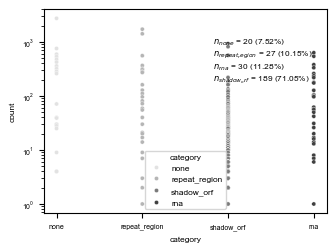

In [ ]:
def figure_1(annotation_df:pd.DataFrame, antifam_descriptions:dict=antifam_descriptions, include_ids:list=include_ids, path:str='../figures/dataset-1_figure-1.pdf'):
    
    fig, ax = get_figure()

    figure_df = annotation_df[annotation_df.index.isin(include_ids)].copy()
    figure_df = pd.DataFrame(figure_df.interpro_signature.value_counts())
    figure_df['description'] = figure_df.index.map(antifam_descriptions)

    conditions = [figure_df.description.str.contains('shadow orf|Antisense to ATP synthase alpha subunit', case=False, regex=True)]
    conditions += [figure_df.description.str.contains('crispr|repeat|Translation of REP sequence', case=False, regex=True)]
    conditions += [figure_df.description.str.contains('rna', case=False)]
    categories = ['shadow_orf', 'repeat_region', 'rna']
    figure_df['category'] = np.select(conditions, categories, default='none')

    sns.scatterplot(figure_df, x='category', y='count', hue='category', palette='Grays')

    text = ''
    for category, df in figure_df.groupby('category'):
        text += get_text(category, len(df), len(figure_df))
    ax.text(0.6, 0.6, text, transform=ax.transAxes)
    ax.set_yscale('log')

    save_figure(fig, path=path)

figure_1(spurious_annotation_df)



In [95]:
if not os.path.exists(f'{DATA_DIR}/real_swissprot.csv'):
    real_df = XMLFile(f'{DATA_DIR}/real_swissprot.xml').to_df()
    real_df.to_csv(f'{DATA_DIR}/real_swissprot.csv')
else:
    real_df = pd.read_csv(f'{DATA_DIR}/real_swissprot.csv', index_col=0)

real_df = real_df[real_df.domain == 'Bacteria'].copy() # Grab only bacterial proteins. 
real_df.to_csv(f'{DATA_DIR}/real.csv')
real_df = real_df[~real_df.index.duplicated(keep='first')]
FASTAFile(df=real_df).write(f'{DATA_DIR}/real.faa')

In [ ]:
def filter_length(df:pd.DataFrame, max_length:int=2000, seq_col:str='seq'):
    mask = df[seq_col].apply(len) >= max_length
    print(f'filter_length: Removing {mask.sum()} sequences exceeding the maximum length of {max_length}.')
    df = df[~mask].copy()
    return df

def filter_duplicate_sequences(df:pd.DataFrame, seq_col:str='seq'):
    # There are some duplicate IDs, as the same gene can be present in multiple genomes. Additionally, there are
    # some entries for identical sequences which do not have the same ID. This can mess up the bisecting k-means clustering, 
    # so I decided to remove these instances. 
    mask = df[seq_col].duplicated(keep='first')
    print(f'filter_duplicate_sequences: Removing {mask.sum()} duplicate sequences from the dataset')
    df = df[~mask].copy()
    return df 

def add_taxonomy_metadata(path:str=f'{DATA_DIR}/dataset.csv'):
    # Downloaded using the download.NCBI.get_taxonomy_metadata function. 
    taxonomy_metadata_df = pd.read_csv(f'{DATA_DIR}/dataset_taxonomy_metadata.tsv', sep='\t', index_col=0)
    cols = ['Phylum name', 'Class name', 'Order name', 'Family name', 'Genus name', 'Species name']

    taxonomy_metadata_df = taxonomy_metadata_df[cols]
    taxonomy_metadata_df = taxonomy_metadata_df.rename(columns={col:col.split()[0].lower() for col in cols})
    taxonomy_metadata_df = fillna(taxonomy_metadata_df) # Fill in empty info with "none."

    dataset_df = pd.read_csv(path, index_col=0)
    assert np.all(np.isin(dataset_df.ncbi_taxonomy_id.unique(), taxonomy_metadata_df.index)), 'add_taxonomy_metadata: Some taxa are missing in the taxonomy metadata file.'
    dataset_df = dataset_df.drop(columns=taxonomy_metadata_df.columns, errors='ignore')
    dataset_df = dataset_df.merge(taxonomy_metadata_df, left_on='ncbi_taxonomy_id', right_index=True, how='left')
    dataset_df.to_csv(path)

In [ ]:
def build_dataset(real_path:str=f'{DATA_DIR}/real.csv', spurious_path:str=f'{DATA_DIR}/spurious.csv', exclude_ids:list=[]):
    dataset_df = list()
    # Library entry name is for accessing the embeddings on HPC.
    dataset_df += [pd.read_csv(real_path, index_col=0).assign(library_entry_name='swissprot_bacteria', label=1)]
    dataset_df += [pd.read_csv(spurious_path, index_col=0).assign(library_entry_name='antifam_bacteria', label=0)]
    dataset_df = pd.concat(dataset_df)

    print(f'build_dataset: Removing {len(exclude_ids)} sequences from the dataset.')
    dataset_df = dataset_df[~dataset_df.index.isin(exclude_ids)]

    dataset_df = fillna(dataset_df, rules={str:'none', bool:False, int:0, float:0})
    dataset_df = filter_duplicate_sequences(dataset_df)
    dataset_df = filter_length(dataset_df)
    
    # For some reason, some of the taxonomy IDs map to different IDs in the NCBI database. 
    taxonomy_id_map = {369930:2576905, 1914757:1768011, 32059:477181, 2859001:2842348, 54064:334542}
    dataset_df['ncbi_taxonomy_id'] = dataset_df.ncbi_taxonomy_id.replace(taxonomy_id_map)

    print(f'build_dataset: Constructed a training dataset with {len(dataset_df)} sequences.')
    dataset_df.to_csv(f'{DATA_DIR}/dataset.csv')
    FASTAFile(df=dataset_df).write(f'{DATA_DIR}/dataset.faa')

build_dataset(exclude_ids=exclude_ids)

if not os.path.exists(f'{DATA_DIR}/dataset_taxonomy_metadata.tsv'):
    dataset_df = pd.read_csv(f'{DATA_DIR}/dataset.csv', index_col=0)
    taxonomy_ids = dataset_df.ncbi_taxonomy_id.unique()
    downloader = download.NCBI()
    taxonomy_metadata_df = downloader.get_taxonomy_metadata(taxonomy_ids, path=f'{DATA_DIR}/dataset_taxonomy_metadata.tsv')

add_taxonomy_metadata(f'{DATA_DIR}/dataset.csv')

build_dataset: Removing 2758 sequences from the dataset.
filter_duplicate_sequences: Removing 136496 duplicate sequences from the dataset
filter_length: Removing 148 sequences exceeding the maximum length of 2000.
build_dataset: Constructed a training dataset with 276590 sequences.


In [ ]:
# ! mmseqs easy-cluster '{DATA_DIR}/dataset.faa' '{DATA_DIR}/dataset_mmseqs' '.' --min-seq-id 0.8

# def load_mmseqs_clusters(path:str):
#     df = pd.read_csv(path, delimiter='\t', names=['cluster_rep_id', 'id'])
#     cluster_ids = {id_:i for i, id_ in enumerate(df.cluster_rep_id.unique())} # Add integer IDs for each cluster. 
#     df['cluster_id'] = [cluster_ids[id_] for id_ in df.cluster_rep_id]
#     df = df.set_index('id')
#     return df

# mmseqs_cluster_df = load_mmseqs_clusters(f'{DATA_DIR}/dataset_mmseqs_cluster.tsv')
# print('Num. MMSeqs clusters:', mmseqs_cluster_df.cluster_id.nunique())
# print('Num. singleton MMSeqs clusters:', (mmseqs_cluster_df.value_counts('cluster_id') > 1).sum())

In [5]:
dataset_df = pd.read_csv(f'{DATA_DIR}/dataset.csv', index_col=0)
print('Num. sequences in dataset:', len(dataset_df))
print('Num. real sequences in dataset:', dataset_df.label.sum(), f'({get_percent(dataset_df.label.sum(), len(dataset_df))})')
print('Num. spurious sequences in dataset:', (dataset_df.label == 0).sum(), f'({get_percent((dataset_df.label == 0).sum(), len(dataset_df))})')

Num. sequences in dataset: 276590
Num. real sequences in dataset: 259366 (93.77%)
Num. spurious sequences in dataset: 17224 (6.23%)


In [ ]:
def table(path:str='../data/figures/dataset-1_table-1.png'):
    datasets = dict()
    datasets['dataset'] = pd.read_csv(f'{DATA_DIR}/dataset.csv', index_col=0)
    datasets['train_dataset'] = pd.read_csv(f'{DATA_DIR}/dataset_train.csv', index_col=0)
    datasets['test_dataset'] = pd.read_csv(f'{DATA_DIR}/dataset_test.csv', index_col=0)

    percent_label = lambda df, label : f'{100 * (df.label == label).sum() / len(df):.2f}%'

    columns = ['size', 'fraction_of_dataset', 'percent_spurious', 'percent_real']
    table_df = pd.DataFrame(index=['dataset', 'train_dataset', 'test_dataset'], columns=columns)

    for dataset, df in datasets.items():
        table_df.loc[dataset, 'size'] = len(df)
        table_df.loc[dataset, 'fraction_of_dataset'] = f'{len(df) / len(datasets['dataset']):.2f}'
        table_df.loc[dataset, 'percent_spurious'] = percent_label(df, 0)
        table_df.loc[dataset, 'percent_real'] = percent_label(df, 1)

    save_table(table_df) 

table()


,size,fraction_of_dataset,percent_spurious,percent_real
dataset,276590,1.00,6.23%,93.77%
train_dataset,221632,0.80,6.30%,93.70%
test_dataset,54958,0.20,5.95%,94.05%
